In [1]:
import numpy as np
import tensorflow as tf


def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

def integrated_gradients(model, input_array, baseline=None, steps=50):
    input_tensor = tf.convert_to_tensor(input_array, dtype=tf.float32)

    if baseline is None:
        baseline = tf.zeros_like(input_tensor)

    alphas = tf.linspace(0.0, 1.0, steps + 1)[:, tf.newaxis, tf.newaxis]
    interpolated = baseline + alphas * (input_tensor - baseline)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        predictions = model(interpolated)

    grads = tape.gradient(predictions, interpolated)
    avg_grads = tf.reduce_mean(grads, axis=0) 

    integrated_grads = (input_tensor - baseline) * avg_grads
    saliency = tf.reduce_sum(tf.abs(integrated_grads), axis=-1)

    return saliency.numpy()

def mutation_saliency(model, sequence):
    original_pred = model(tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.zeros(sequence.shape[0])

    int_to_vec = {
        'A': [1,0,0,0],
        'C': [0,1,0,0],
        'G': [0,0,1,0],
        'T': [0,0,0,1]
    }
    vec_to_base = {tuple(v): k for k, v in int_to_vec.items()}

    # Collect all single-nucleotide mutations
    mutations = []
    positions = []
    
    for i, base_vec in enumerate(sequence):
        base = vec_to_base.get(tuple(base_vec), None)
        if base is None:
            continue
        for alt_base in "ACGT":
            if alt_base == base:
                continue
            mutated = sequence.copy()
            mutated[i] = int_to_vec[alt_base]
            mutations.append(mutated)
            positions.append(i)

    # Run all mutations in a single batch
    mutations = np.array(mutations)
    preds = model(tf.convert_to_tensor(mutations, dtype=tf.float32)).numpy().flatten()

    # Aggregate saliency by position
    for pred, pos in zip(preds, positions):
        delta = abs(pred - original_pred)
        saliency[pos] += delta / 3

    return saliency

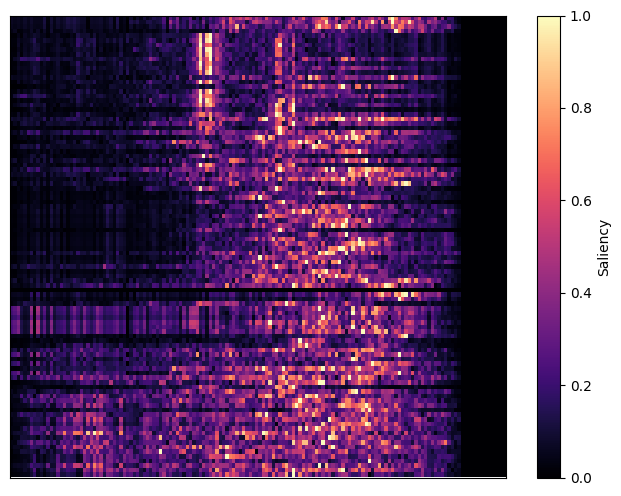

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# ----------------------- Generate Saliency Maps -----------------------

def generate_saliency_map(model, sequence):
    input_tensor = tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)[0, 0]
    gradient = tape.gradient(prediction, input_tensor)
    gradient = tf.norm(gradient, axis=-1)
    return (gradient / tf.reduce_max(gradient)).numpy()

# -------------------- Main Execution --------------------

# load data and preprocess
df = pd.read_csv('Data/LaFleur_supp.csv')
X, y = combine_columns(df)
X = preprocess_sequences(X)
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Variables for plotting
model_filename='Models/CNN_6_1_2.keras'
data=X_test
y_vals=y_test
num_samples=100
random_state=1

model = load_model(model_filename)

# ----------------------- Generate Saliency Maps -----------------------

# randomly select "num_samples" sequences from the data
np.random.seed(random_state)
indices = np.random.choice(len(data), size=min(num_samples, len(data)), replace=False)
sequences = data[indices]
y_subset = y_vals[indices]

predictions = []
saliency_maps = []
relative_saliency_maps = []

for seq in sequences:
    pred = model(tf.convert_to_tensor(seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(generate_saliency_map(model, seq))
    saliency = np.nan_to_num(saliency)
    
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)

# ------------------------- Plot Saliency Map -------------------------

plt.figure(figsize=(8, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)
plt.xticks([])
plt.yticks([])
plt.colorbar(label='Saliency')
plt.show()


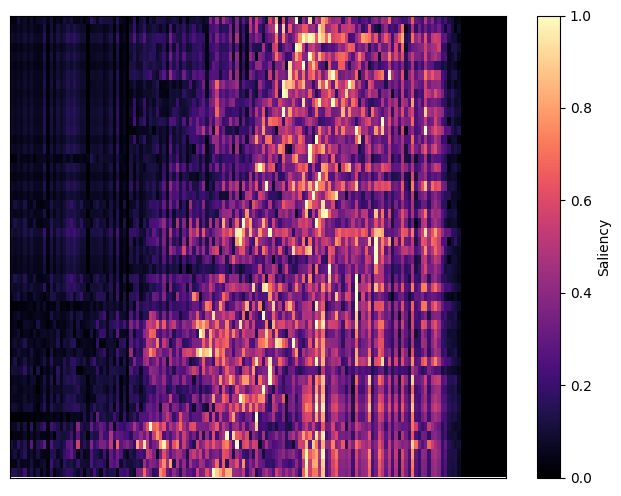

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# -------------------- Main Execution --------------------

# load data and preprocess
df = pd.read_csv('Data/Saliency/generated_spacers.csv')
sequences = preprocess_sequences(df['Promoter Sequence'].astype(str))

# Variables for plotting
model_filename='Models/CNN_6_1_2.keras'
model = load_model(model_filename)

# ----------------------- Generate Saliency Maps -----------------------

saliency_maps = []

for seq in sequences:
    pred = model(tf.convert_to_tensor(seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(generate_saliency_map(model, seq))
    saliency = np.nan_to_num(saliency)
    saliency_maps.append(saliency)

saliency_matrix = np.vstack(saliency_maps)

# ------------------------- Plot Saliency Map -------------------------

plt.figure(figsize=(8, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)
plt.xticks([])
plt.yticks([])
plt.colorbar(label='Saliency')
plt.show()


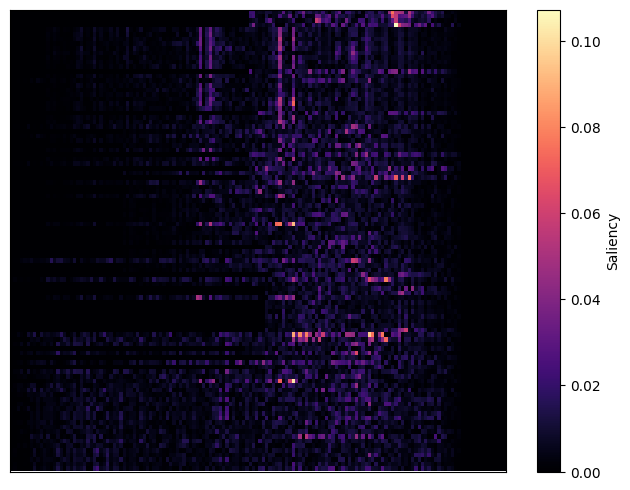

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])


# -------------------- Main Execution --------------------

# load data and preprocess
df = pd.read_csv('Data/LaFleur_supp.csv')
X, y = combine_columns(df)
X = preprocess_sequences(X)
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Variables for plotting
model_filename='Models/CNN_6_1_2.keras'
data=X_test
y_vals=y_test
num_samples=100
random_state=1

model = load_model(model_filename)

# ----------------------- Generate Saliency Maps -----------------------

# randomly select "num_samples" sequences from the data
np.random.seed(random_state)
indices = np.random.choice(len(data), size=min(num_samples, len(data)), replace=False)
sequences = data[indices]
y_subset = y_vals[indices]

predictions = []
saliency_maps = []
relative_saliency_maps = []

for seq in sequences:
    pred = model(tf.convert_to_tensor(seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(integrated_gradients(model, seq))
    saliency = np.nan_to_num(saliency)
    
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)

# ------------------------- Plot Saliency Map -------------------------

plt.figure(figsize=(8, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)
plt.xticks([])
plt.yticks([])
plt.colorbar(label='Saliency')
plt.show()


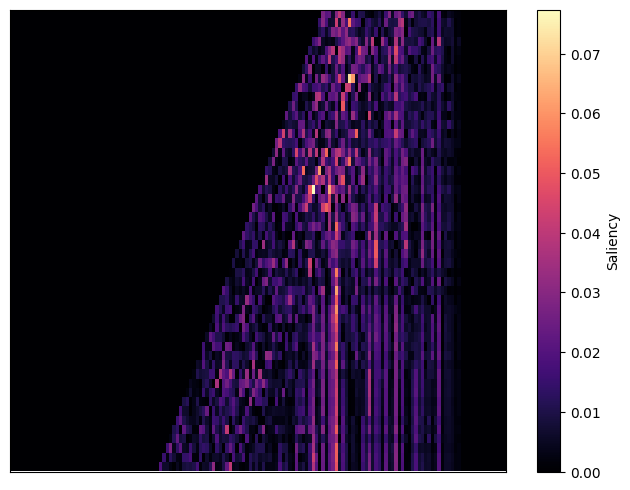

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import tensorflow as tf
from tensorflow.keras.models import load_model  # type: ignore

# -------------------- Data Preprocessing Functions --------------------

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# -------------------- Main Execution --------------------

# load data and preprocess
df = pd.read_csv('Data/Saliency/generated_spacers.csv')
sequences = preprocess_sequences(df['Promoter Sequence'].astype(str))

# Variables for plotting
model_filename='Models/CNN_6_1_2.keras'
model = load_model(model_filename)

# ----------------------- Generate Saliency Maps -----------------------

saliency_maps = []

for seq in sequences:
    pred = model(tf.convert_to_tensor(seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(integrated_gradients(model, seq))
    saliency = np.nan_to_num(saliency)
    saliency_maps.append(saliency)

saliency_matrix = np.vstack(saliency_maps)

# ------------------------- Plot Saliency Map -------------------------

plt.figure(figsize=(8, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)
plt.xticks([])
plt.yticks([])
plt.colorbar(label='Saliency')
plt.show()


C:\Users\rsore\AppData\Local\Temp\ipykernel_22152\202224116.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


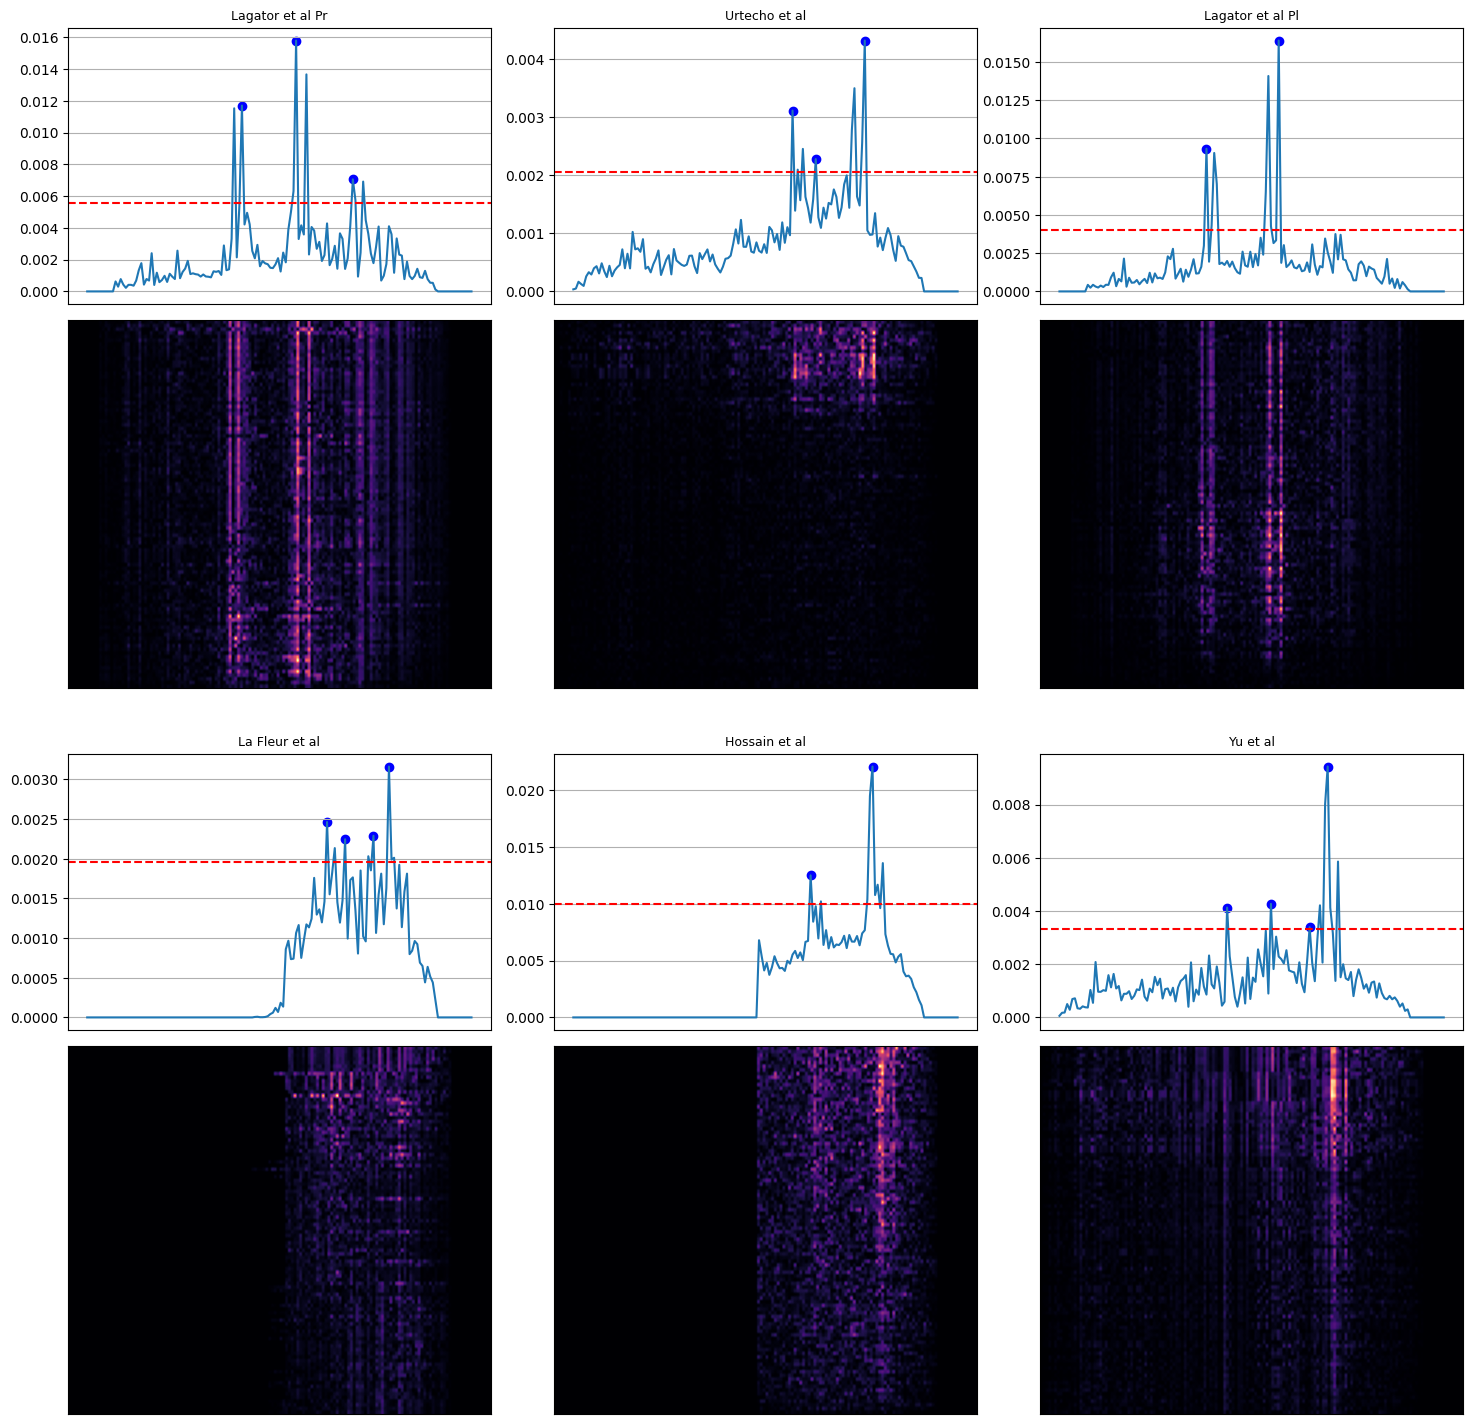

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model  # type: ignore
from scipy.signal import find_peaks
import matplotlib.gridspec as gridspec

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# ----------------------- Generate Saliency Maps -----------------------

def plot_saliency_map_grid_combined(
    model_filename,
    data,
    num_samples=100,
    random_state=42,
    ax_line=None,
    ax_imshow=None,
    title=None,
    colorbar=False,
):
    model = load_model(model_filename)
    np.random.seed(random_state)
    sequences = data[np.random.choice(len(data), size=min(num_samples, len(data)), replace=False)]
    saliency_maps = []
    predictions = []

    for seq in sequences:
        pred = model(tf.convert_to_tensor(seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
        saliency = np.abs(integrated_gradients(model, seq)).flatten()
        saliency = np.nan_to_num(saliency)
        saliency = pred * saliency
        predictions.append(pred)
        saliency_maps.append(saliency)

    saliency_maps = [saliency_maps[i] for i in np.argsort(predictions)[::-1]]
    averaged_saliency_maps = np.mean(np.stack(saliency_maps), axis=0)
    q3_iqr = np.percentile(averaged_saliency_maps, 95)
    peaks, _ = find_peaks(averaged_saliency_maps, height=q3_iqr, distance=5)

    # Line plot
    if ax_line:
        ax_line.plot(averaged_saliency_maps)
        ax_line.axhline(q3_iqr, color="red", linestyle="--")
        ax_line.scatter(peaks, averaged_saliency_maps[peaks], color="blue")
        ax_line.set_title(f"{title}", fontsize=9)
        ax_line.set_xticks([])
        ax_line.grid(True)

    # Heatmap
    saliency_matrix = np.vstack(saliency_maps)
    im = ax_imshow.imshow(
        saliency_matrix,
        cmap='magma',
        aspect='auto',
        vmin=saliency_matrix.min(),
        vmax=saliency_matrix.max()
    )
    ax_imshow.set_xticks([])
    ax_imshow.set_yticks([])
    if colorbar:
        plt.colorbar(im, ax=ax_imshow, fraction=0.046, pad=0.04)
    return im

# -------------------- Main Execution --------------------

# Load data
df = pd.read_csv('Data/LaFleur_supp.csv')
X, y = combine_columns(df)
X = preprocess_sequences(X)
files = df['File Name'].astype(str)

# Train/test split
indices = np.arange(len(X))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_test = X[test_idx]
y_test = y[test_idx]
files_test = files.iloc[test_idx]

# Define files (must match exactly from the dataset)
file_names = ['Lagator et al Pr', 'Urtecho et al', 'Lagator et al Pl', 'La Fleur et al', 'Hossain et al', 'Yu et al']
num_files = len(file_names)

# Create 2x3 grid layout
fig = plt.figure(figsize=(18, 18))
outer_gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)

for idx, file_name in enumerate(file_names):
    mask = files_test == file_name
    data_subset = X_test[mask.values]
    if len(data_subset) == 0:
        continue

    row, col = divmod(idx, 3)
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[row, col], height_ratios=[1.5, 2], hspace=0.05)

    ax_line = fig.add_subplot(inner_gs[0])
    ax_imshow = fig.add_subplot(inner_gs[1])

    plot_saliency_map_grid_combined(
        model_filename='Models/CNN_6_1_2.keras',
        data=data_subset,
        num_samples=100,
        random_state=1,
        ax_line=ax_line,
        ax_imshow=ax_imshow,
        title=file_name,
        colorbar=False
    )

plt.tight_layout()
plt.show()

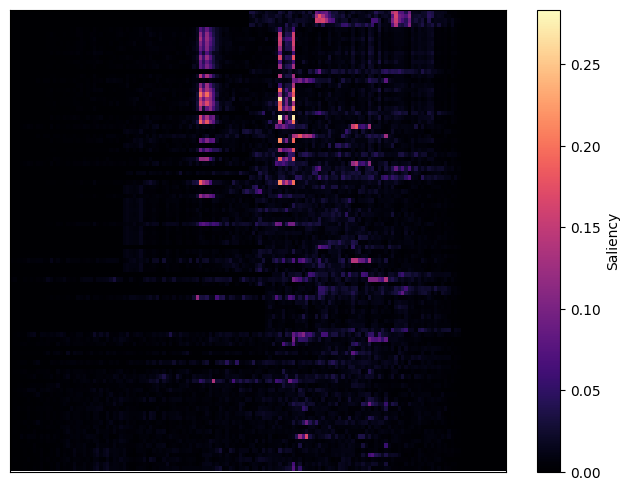

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
from tensorflow.keras.models import load_model  # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# ----------------------- Generate Saliency Maps -----------------------

def mutation_saliency(model, sequence):
    original_pred = model(tf.convert_to_tensor(sequence[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.zeros(sequence.shape[0])

    int_to_vec = {
        'A': [1,0,0,0],
        'C': [0,1,0,0],
        'G': [0,0,1,0],
        'T': [0,0,0,1]
    }
    vec_to_base = {tuple(v): k for k, v in int_to_vec.items()}

    # Collect all single-nucleotide mutations
    mutations = []
    positions = []
    
    for i, base_vec in enumerate(sequence):
        base = vec_to_base.get(tuple(base_vec), None)
        if base is None:
            continue
        for alt_base in "ACGT":
            if alt_base == base:
                continue
            mutated = sequence.copy()
            mutated[i] = int_to_vec[alt_base]
            mutations.append(mutated)
            positions.append(i)

    # Run all mutations in a single batch
    mutations = np.array(mutations)
    preds = model(tf.convert_to_tensor(mutations, dtype=tf.float32)).numpy().flatten()

    # Aggregate saliency by position
    for pred, pos in zip(preds, positions):
        delta = abs(pred - original_pred)
        saliency[pos] += delta / 3

    return saliency

# -------------------- Main Execution --------------------

# load data and preprocess
df = pd.read_csv('Data/LaFleur_supp.csv')
X, y = combine_columns(df)
X = preprocess_sequences(X)
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Variables for plotting
model_filename='Models/CNN_6_1_2.keras'
data=X_test
y_vals=y_test
num_samples=100
random_state=1

model = load_model(model_filename)

# ----------------------- Generate Saliency Maps -----------------------

# randomly select "num_samples" sequences from the data
np.random.seed(random_state)
indices = np.random.choice(len(data), size=min(num_samples, len(data)), replace=False)
sequences = data[indices]
y_subset = y_vals[indices]

predictions = []
saliency_maps = []
relative_saliency_maps = []

for seq in sequences:
    pred = model(tf.convert_to_tensor(seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
    saliency = np.abs(mutation_saliency(model, seq))
    saliency = np.nan_to_num(saliency)
    
    predictions.append(pred)
    saliency_maps.append(saliency)
    relative_saliency_maps.append(pred * saliency)

# Sort by predictions
sort_idx = np.argsort(predictions)[::-1]
predictions = [predictions[i] for i in sort_idx]
saliency_maps = [saliency_maps[i] for i in sort_idx]
relative_saliency_maps = [relative_saliency_maps[i] for i in sort_idx]
y_subset = [y_subset[i] for i in sort_idx]

saliency_matrix = np.vstack(saliency_maps)
relative_saliency_matrix = np.vstack(relative_saliency_maps)

# ------------------------- Plot Saliency Map -------------------------

plt.figure(figsize=(8, 6))
plt.imshow(
    saliency_matrix,
    cmap='magma',
    aspect='auto',
    vmin=saliency_matrix.min(),
    vmax=saliency_matrix.max()
)
plt.xticks([])
plt.yticks([])
plt.colorbar(label='Saliency')
plt.show()


C:\Users\rsore\AppData\Local\Temp\ipykernel_22152\2106103141.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


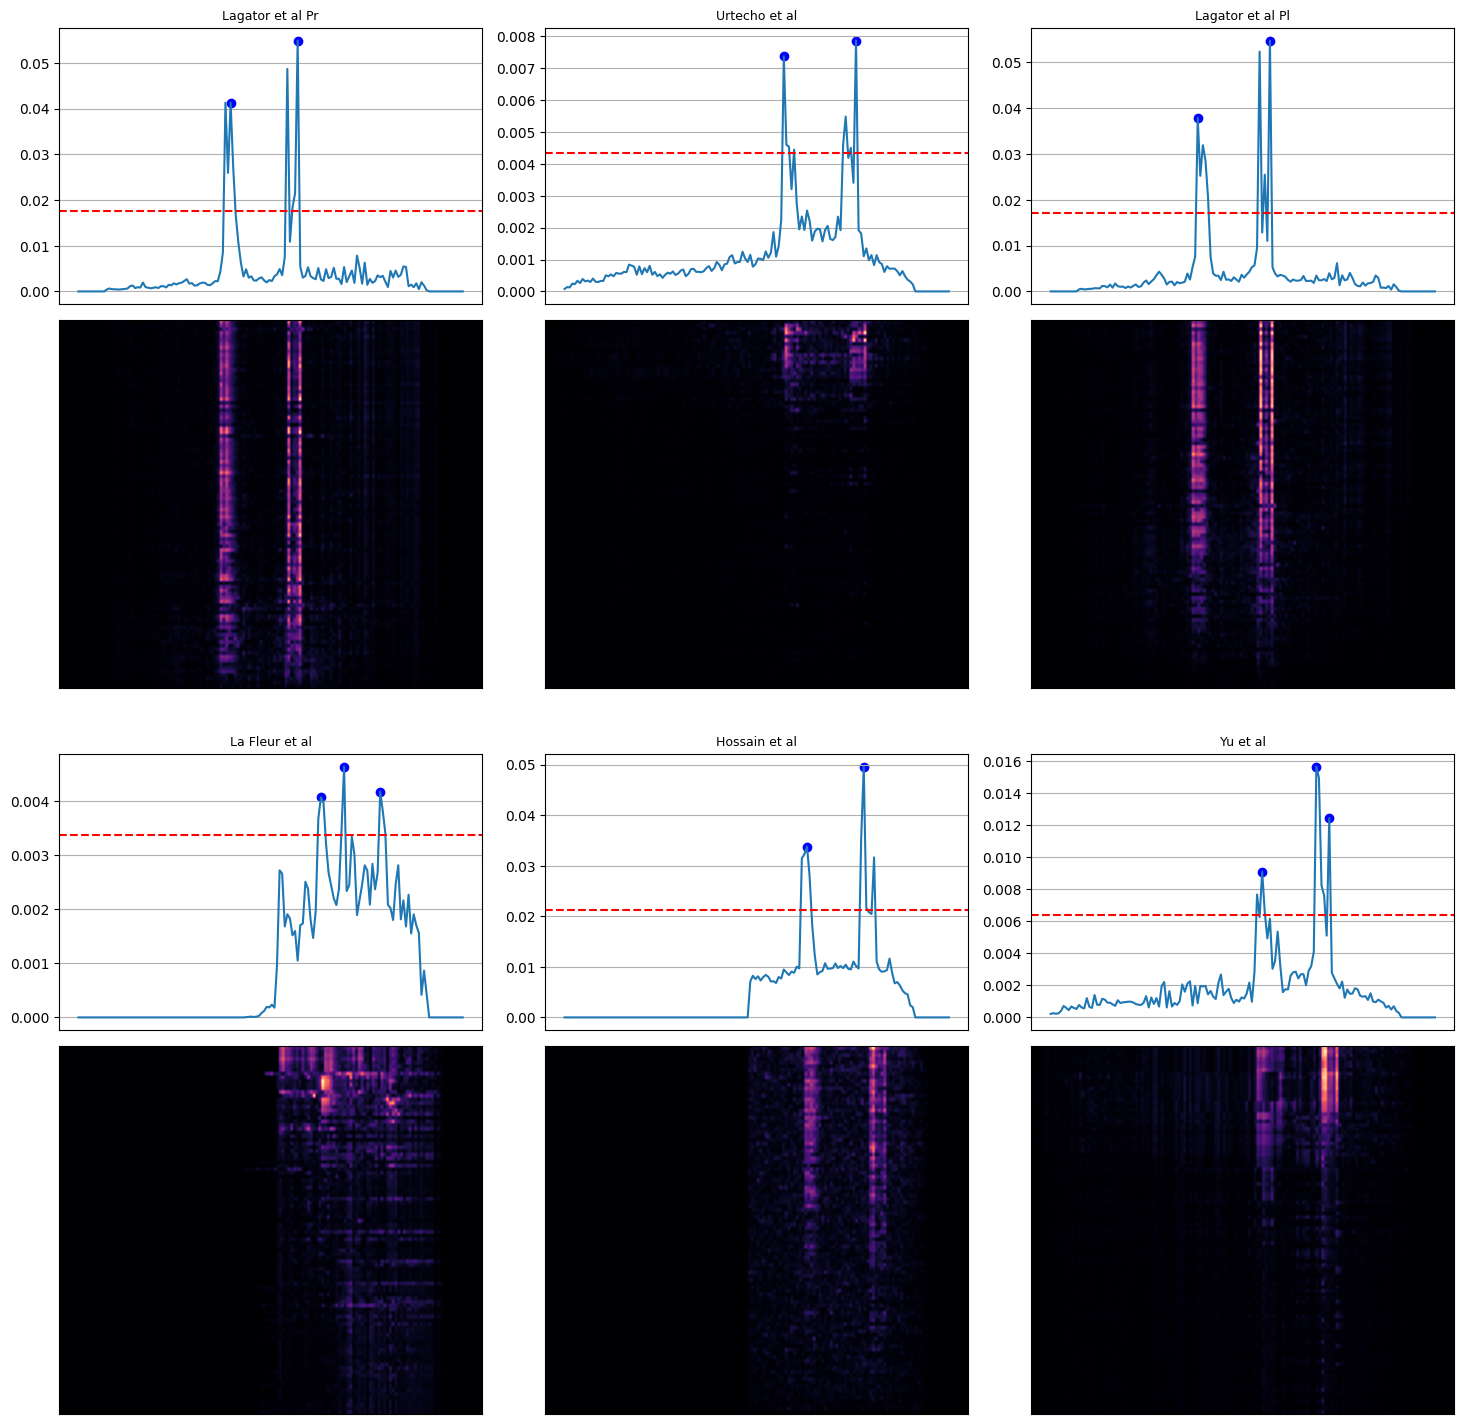

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model  # type: ignore
from scipy.signal import find_peaks
import matplotlib.gridspec as gridspec

# -------------------- Data Preprocessing Functions --------------------

def combine_columns(df):
    X = df['Promoter Sequence'].astype(str)
    y = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']].abs())
    return X, y

def padded_one_hot_encode(seq):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    return [mapping[n.upper()] for n in seq]

def preprocess_sequences(X, max_length=150):
    return np.array([padded_one_hot_encode(seq.zfill(max_length)) for seq in X])

# ----------------------- Generate Saliency Maps -----------------------

def plot_saliency_map_grid_combined(
    model_filename,
    data,
    num_samples=100,
    random_state=42,
    ax_line=None,
    ax_imshow=None,
    title=None,
    colorbar=False,
):
    model = load_model(model_filename)
    np.random.seed(random_state)
    sequences = data[np.random.choice(len(data), size=min(num_samples, len(data)), replace=False)]
    saliency_maps = []
    predictions = []

    for seq in sequences:
        pred = model(tf.convert_to_tensor(seq[np.newaxis, ...], dtype=tf.float32))[0, 0].numpy()
        saliency = np.abs(mutation_saliency(model, seq)).flatten()
        saliency = np.nan_to_num(saliency)
        saliency = pred * saliency
        predictions.append(pred)
        saliency_maps.append(saliency)

    saliency_maps = [saliency_maps[i] for i in np.argsort(predictions)[::-1]]
    averaged_saliency_maps = np.mean(np.stack(saliency_maps), axis=0)
    q3_iqr = np.percentile(averaged_saliency_maps, 95)
    peaks, _ = find_peaks(averaged_saliency_maps, height=q3_iqr, distance=5)

    # Line plot
    if ax_line:
        ax_line.plot(averaged_saliency_maps)
        ax_line.axhline(q3_iqr, color="red", linestyle="--")
        ax_line.scatter(peaks, averaged_saliency_maps[peaks], color="blue")
        ax_line.set_title(f"{title}", fontsize=9)
        ax_line.set_xticks([])
        ax_line.grid(True)

    # Heatmap
    saliency_matrix = np.vstack(saliency_maps)
    im = ax_imshow.imshow(
        saliency_matrix,
        cmap='magma',
        aspect='auto',
        vmin=saliency_matrix.min(),
        vmax=saliency_matrix.max()
    )
    ax_imshow.set_xticks([])
    ax_imshow.set_yticks([])
    if colorbar:
        plt.colorbar(im, ax=ax_imshow, fraction=0.046, pad=0.04)
    return im

# -------------------- Main Execution --------------------

# Load data
df = pd.read_csv('Data/LaFleur_supp.csv')
X, y = combine_columns(df)
X = preprocess_sequences(X)
files = df['File Name'].astype(str)

# Train/test split
indices = np.arange(len(X))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

X_test = X[test_idx]
y_test = y[test_idx]
files_test = files.iloc[test_idx]

# Define files (must match exactly from the dataset)
file_names = ['Lagator et al Pr', 'Urtecho et al', 'Lagator et al Pl', 'La Fleur et al', 'Hossain et al', 'Yu et al']
num_files = len(file_names)

# Create 2x3 grid layout
fig = plt.figure(figsize=(18, 18))
outer_gs = gridspec.GridSpec(2, 3, wspace=0.15, hspace=0.1)

for idx, file_name in enumerate(file_names):
    mask = files_test == file_name
    data_subset = X_test[mask.values]
    if len(data_subset) == 0:
        continue

    row, col = divmod(idx, 3)
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[row, col], height_ratios=[1.5, 2], hspace=0.05)

    ax_line = fig.add_subplot(inner_gs[0])
    ax_imshow = fig.add_subplot(inner_gs[1])

    plot_saliency_map_grid_combined(
        model_filename='Models/CNN_6_1_2.keras',
        data=data_subset,
        num_samples=100,
        random_state=1,
        ax_line=ax_line,
        ax_imshow=ax_imshow,
        title=file_name,
        colorbar=False
    )

plt.tight_layout()
plt.show()